# IPIP 50 Items Example
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/psyphh/xifa/blob/master/examples/ipip50.ipynb)

In this example, we will demonstrate how to use `xifa` to analyze a [`ipip50`](http://openpsychometrics.org/_rawdata/BIG5.zip) dataset from [openspychometrics](https://openpsychometrics.org/_rawdata/) with both exploratory and confirmatory graded response models (GRMs; [Semejima, 1969](https://link.springer.com/article/10.1007%2FBF03372160)). The `ipip50` dataset include responses of 19719 subjects on 50 items from International Personality Item Pool (IPIP; [Goldberg, 1992](https://doi.org/10.1037/1040-3590.4.1.26)).

To open this notebook on [Google Colab](https://colab.research.google.com/), please use [this link](http://colab.research.google.com/github/psyphh/xifa/blob/master/examples/ipip50.ipynb). After logging Colab, don't forget to turn on GPU by
```
Go to Menu > Runtime > Change runtime > Change hardware acceleration to GPU.
```

## Environment Setup
For first running this notebook, please install `xifa` via
```
pip install --upgrade xifa
```
on terminal, or
```
!pip install --upgrade xifa
```
on jupyter notebook (or Colab).

Let's install `xifa` on jupyter notebook!

In [1]:
!pip install --upgrade xifa

  Attempting uninstall: xifa
    Found existing installation: xifa 0.1.7
    Uninstalling xifa-0.1.7:
      Successfully uninstalled xifa-0.1.7


Note that `xifa` is established on [`jax`](https://github.com/google/jax), which is officially supported only on Linux and Mac systems. Therefore, if you use a local Windows machine, `xifa` might not work.

First of all, we import all necessary packages.

In [2]:
import os
import zipfile

import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from statsmodels.multivariate.factor_rotation import rotate_factors

from xifa import GRM

By default, `jax` uses single precision for floating points arithmetics. To enable double precision arithmetics, try

In [3]:
jax.config.update("jax_enable_x64", True)

## Data Preparation

In the next step, we download the `ipip50` dataset, unzip it, and read it as a pandas dataframe.

In [4]:
def download_dataset(dataset_url,
                     dataset_name):
    req = requests.get(dataset_url, allow_redirects=True)
    open(dataset_name + '.zip',"wb").write(req.content)
    zipfile.ZipFile(dataset_name + '.zip').extractall()
    os.remove(dataset_name+'.zip')

dataset_url = "http://openpsychometrics.org/_rawdata/BIG5.zip"
dataset_name = "ipip50"
download_dataset(dataset_url, dataset_name)
data = pd.read_csv("BIG5/data.csv", sep="\t").iloc[:,-50:]

The dataset only includes one observation with missing values (which is coded by `0` so we need to replace it by `np.nan`). However, the observation didn't response any items. Hence, we delete it.

In [5]:
data = data.replace(0, np.nan)
data = data.dropna()

If missing data are presented, `xifa` uses the so-called full-information approach for estimation. Therefore, it is unnecessary to explicitly handle `np.nan`. The full-information estimation could still yield a consistent estimator if the assumption of missing at random (MAR) is satisfied ([Rubin, 1976](https://doi.org/10.2307/2335739)).

`xifa` requires the ordered responses to be coded from `0` to `max_cats-1`, where `max_cats` is the maximal number of ordered categories. Because the original responses are coded from `1` to `max_cats`, we need to subtract all values by 1.

In [6]:
data = data - 1.0

Note that `xifa` could handle items with different numbers of categories. In that case, just code item `i` from `0` to `n_cats_i-1`, where `n_cats_i` is the number of categories of item `i`.

We then reverse the coding for the "negative items" and use the heat map of correlation matrix to check whether our reversing is correct.

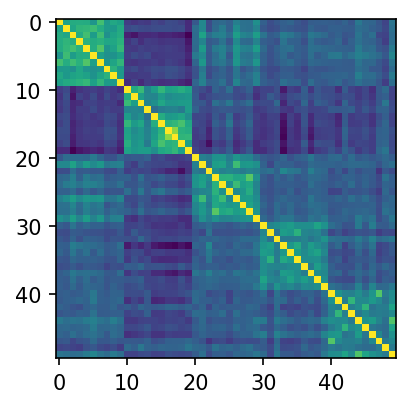

In [7]:
negative_items = ["E2", "E4", "E6", "E8", "E10",
                  "N2", "N4",
                  "A1", "A3", "A5", "A7",
                  "C2", "C4", "C6", "C8",
                  "O2", "O4", "O6"]
data[negative_items] = 4 - data[negative_items]

plt.figure(figsize=(3, 3), dpi=150)
plt.imshow(data.corr(),
           cmap='viridis')
plt.show()

## Exploratory IFA Implementation
Now, we conduct exploratory IFA by using the `GRM` object imported from `xifa`. To initialize a `GRM` instance, a dataset (`data`) and a number of factors (`n_factors`) must be specified. The data must be a two dimensional array (`n_cases * n_items`) that can be transformed to `jax.numpy.array`.

In [8]:
grm = GRM(data=data, 
          n_factors=5)

A GRM Object is Initialized for Exploratory Analysis.
 + Number of Cases: 19718
 + Number of Items: 50
 + Number of Factors: 5
 + Number of Categories: 5


After initialization, by default, a summary for model will be printed. This can be turn off by setting `verbose=False`.

The marginal maximum likelihood (MML) estimation can be implemented by the `fit()` method. `xifa` implements MML by a vectorized Metropolis-Hastings Robbins-Monro (MH-RM) algorithm. The algorithm includes two stages. The first stage updates the parameter estimate by a stochastic expectation-maximization (StEM) algorithm. The second stage conducts stochastic approximation (SA) to refine the estimate.

In [9]:
grm.fit()

Fitting Process is Started.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Converged after 164 Iterations (11.81 sec).


In this example, CPU takes about 3-8 minutes to finish the optimization job. If any GPU is available, the job can be speed up. On Colab with GPU, the job takes about 30 seconds (depending on the GPU resource availability).


The MML parameter estimate is stored in the `params` attribute. `params` is a dictionary with three keys: `intercept` for the intercept vector, `loading` for the factor loading matrix, and `corr` for the factor correlation matrix. For example, the estimated factor correlation matrix can be extracted by

In [10]:
print(np.round(grm.params["corr"], 3))

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


The factor correlations are all zero because the exploratory analysis assumes orthogonal factors by convention. To capture the relationships among items and factors appropriately, we use `rotate_factors` in `statsmodels` to obtain a rotated loading matrix and factor correlations

In [11]:
L, T  = rotate_factors(
    grm.params["loading"],
    'quartimin', 0.5)
print("Rotated Factor Loading Matrix: \n",
      np.round(L, 2))
print("Factor Correlation Matrix: \n",
      np.round(T.T @ T, 2))

Rotated Factor Loading Matrix: 
 [[-0.01  0.15  0.04  0.12 -1.82]
 [-0.03 -0.06  0.14  0.29 -1.9 ]
 [ 0.16 -0.43 -0.24 -0.49 -1.96]
 [ 0.06  0.21  0.02 -0.1  -2.08]
 [-0.17 -0.32 -0.19  0.11 -2.29]
 [-0.53 -0.18  0.02 -0.01 -1.42]
 [ 0.05 -0.13  0.    0.02 -2.34]
 [-0.04  0.35  0.18  0.12 -1.45]
 [-0.27  0.3   0.07  0.15 -1.61]
 [ 0.06  0.18  0.04 -0.25 -1.87]
 [ 0.14 -0.32 -0.15  1.86  0.19]
 [ 0.12 -0.05 -0.22  1.15  0.15]
 [-0.06 -0.61 -0.27  1.59  0.36]
 [-0.15 -0.16  0.15  0.66  0.31]
 [ 0.22 -0.04  0.09  1.3  -0.01]
 [ 0.21 -0.24 -0.01  2.3   0.02]
 [-0.07  0.12  0.2   2.13 -0.16]
 [-0.02  0.15  0.22  2.38 -0.15]
 [-0.03  0.39 -0.16  2.2  -0.06]
 [-0.19 -0.08  0.27  1.56  0.57]
 [-0.08 -1.11  0.03 -0.23  0.08]
 [-0.14 -1.33  0.14 -0.14 -0.76]
 [ 0.22 -0.96 -0.36 -0.64  0.38]
 [-0.01 -2.49 -0.01  0.04  0.17]
 [ 0.02 -1.88  0.13 -0.13 -0.17]
 [ 0.21 -1.58 -0.06  0.31  0.13]
 [-0.02 -1.74  0.13 -0.3  -0.71]
 [-0.03 -1.5  -0.13 -0.09 -0.12]
 [-0.17 -2.07 -0.12  0.27 -0.08]
 [-0.17 -0

The optimization history is stored in the `trace` attribute. To see how the complete data loss changes over iterations, we may use

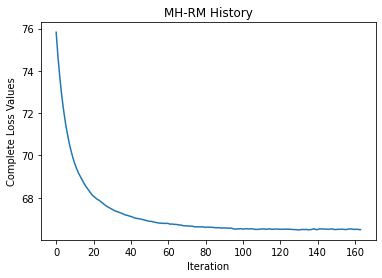

In [12]:
plt.plot(grm.trace["closs"])
plt.ylabel('Complete Loss Values')
plt.xlabel('Iteration')
plt.title('MH-RM History')
plt.show()

## Confirmatory IFA Implementation
 Finally, we conduct a confirmatory analysis with GRM. For a confirmatory analysis, an additional argument `patterns` must be given. `patterns` is a `dict` (`python` dictionary) with two keys: `loading` and `corr`. `patterns["loading"]` is also a `dict` to specify the relationships among items and factors. On the other hand, `patterns["corr"]` is for the pattern of factor correlations. If either `loading` or `corr` is not included in `pattern`, its corresponding parameter matrix will be freely estimated.

 For example, we can set an independent cluster structure for the loading matrix in this `ipip50` example by

In [13]:
n_factors = 5
n_items = 50
items_per_factor = int(n_items / n_factors)
patterns = {
    "loading":{m: list(
        range(m * items_per_factor, (m + 1) * items_per_factor)) for m in range(n_factors)}}
print(patterns["loading"])

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 3: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 4: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]}


We can see that `patterns["loading"]` specifies the relationship among items and factors through their indices (starting form 0) by a `dict` (`key` for indices of factors and `value` for indices of corresponding items). Note that we didn't specify a `patterns["corr"]` and hence all of the correlations among factors will be freely estimated.

If `patterns` is specified when initializing `GRM`, the model will be treated as confirmatory.

In [14]:
grm = GRM(data=data, 
          n_factors=5,
          patterns=patterns)

A GRM Object is Initialized for Confirmatory Analysis.
 + Number of Cases: 19718
 + Number of Items: 50
 + Number of Factors: 5
 + Number of Categories: 5


We can still use `fit()` method to calculate a parameter estimate, i.e.,

In [15]:
grm.fit()

Fitting Process is Started.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Converged after 196 Iterations (11.26 sec).


The corresponding estimated loading matrix and correlation matrix are

In [16]:
print("Factor Loading Matrix: \n",
      np.round(grm.params["loading"], 2))
print("Factor Correlation Matrix: \n",
      np.round(grm.params["corr"], 2))

Factor Loading Matrix: 
 [[1.7  0.   0.   0.   0.  ]
 [1.83 0.   0.   0.   0.  ]
 [2.05 0.   0.   0.   0.  ]
 [2.03 0.   0.   0.   0.  ]
 [2.43 0.   0.   0.   0.  ]
 [1.57 0.   0.   0.   0.  ]
 [2.38 0.   0.   0.   0.  ]
 [1.24 0.   0.   0.   0.  ]
 [1.46 0.   0.   0.   0.  ]
 [1.89 0.   0.   0.   0.  ]
 [0.   1.83 0.   0.   0.  ]
 [0.   1.17 0.   0.   0.  ]
 [0.   1.43 0.   0.   0.  ]
 [0.   0.81 0.   0.   0.  ]
 [0.   1.32 0.   0.   0.  ]
 [0.   2.29 0.   0.   0.  ]
 [0.   2.14 0.   0.   0.  ]
 [0.   2.43 0.   0.   0.  ]
 [0.   2.02 0.   0.   0.  ]
 [0.   1.77 0.   0.   0.  ]
 [0.   0.   1.07 0.   0.  ]
 [0.   0.   1.59 0.   0.  ]
 [0.   0.   0.74 0.   0.  ]
 [0.   0.   2.25 0.   0.  ]
 [0.   0.   1.94 0.   0.  ]
 [0.   0.   1.32 0.   0.  ]
 [0.   0.   1.97 0.   0.  ]
 [0.   0.   1.57 0.   0.  ]
 [0.   0.   2.04 0.   0.  ]
 [0.   0.   1.13 0.   0.  ]
 [0.   0.   0.   1.47 0.  ]
 [0.   0.   0.   1.24 0.  ]
 [0.   0.   0.   0.85 0.  ]
 [0.   0.   0.   1.61 0.  ]
 [0.   0.   0.   1.6  0